In [15]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, SpatialDropout1D



## 데이터 불러오기

* 2만개 테스트 데이터 셋 사용

In [16]:
# CSV 파일 불러오기
data = pd.read_csv('new_Hotel_reviews_20k.csv')
data.drop_duplicates(inplace=True)


## NLP(텍스트 데이터 전처리)

* 특수문자 제거
* 토큰화 
* 불용어 제거 및 표제어 추출
* 이상치 제거

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# 텍스트 데이터 전처리
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r"[^a-zA-Z]+", " ", text)

    # 단어 토큰화
    words = word_tokenize(text)

    # 불용어 제거 및 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]

    # 리스트를 공백을 포함한 문자열로 변환
    processed_text = ' '.join(words)

    return processed_text

# 텍스트 정제 및 불용어 제거
data['review_full'] = data['review_full'].apply(preprocess_text)

# Count the length of each text
text_lengths = data['review_full'].apply(lambda x: len(x.split()))

# Calculate the IQR
Q1 = text_lengths.quantile(0.25)
Q3 = text_lengths.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier removal
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data = data[(text_lengths >= lower_bound) & (text_lengths <= upper_bound)]

reviews = data['review_full']
labels = data['rating_review']




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
# 시퀀스의 최대 길이 계산
max_sequence_length = max([len(seq) for seq in sequences])

# 패딩 적용
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)


# 레이블 데이터 정규화
normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

train_padded = padded_sequences[::2]
train_normalized_label = normalized_labels[::2]
test_padded = padded_sequences[1::2]
test_normalized_label = normalized_labels[1::2]
test_label = labels[1::2]



88


## 사전 모델 생성 및 테스트

In [13]:
# LSTM 모델 구축
embedding_dim = 100
vocab_size = len(word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 88, 100)           2212100   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 88, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,254,405
Trainable params: 2,254,405
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# 모델 훈련
history = model.fit(train_padded, train_normalized_label, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
231/231 [==============================] - 11s 38ms/step - loss: 0.0714 - val_loss: 0.0388
Epoch 2/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0251 - val_loss: 0.0408
Epoch 3/10
231/231 [==============================] - 9s 38ms/step - loss: 0.0152 - val_loss: 0.0415
Epoch 4/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0101 - val_loss: 0.0448
Epoch 5/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0077 - val_loss: 0.0479
Epoch 6/10
231/231 [==============================] - 8s 36ms/step - loss: 0.0064 - val_loss: 0.0497
Epoch 7/10
231/231 [==============================] - 8s 36ms/step - loss: 0.0054 - val_loss: 0.0496
Epoch 8/10
231/231 [==============================] - 9s 38ms/step - loss: 0.0043 - val_loss: 0.0496
Epoch 9/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0036 - val_loss: 0.0501
Epoch 10/10
231/231 [==============================] - 9s 39ms/step - loss: 0.0031 - val_l

'\nEpoch 1/10\n231/231 [==============================] - 11s 40ms/step - loss: 0.0681 - val_loss: 0.0408\nEpoch 2/10\n231/231 [==============================] - 9s 38ms/step - loss: 0.0252 - val_loss: 0.0487\nEpoch 3/10\n231/231 [==============================] - 9s 38ms/step - loss: 0.0157 - val_loss: 0.0431\nEpoch 4/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0110 - val_loss: 0.0478\nEpoch 5/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0081 - val_loss: 0.0476\nEpoch 6/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0064 - val_loss: 0.0493\nEpoch 7/10\n231/231 [==============================] - 9s 40ms/step - loss: 0.0053 - val_loss: 0.0522\nEpoch 8/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0043 - val_loss: 0.0506\nEpoch 9/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0035 - val_loss: 0.0509\nEpoch 10/10\n231/231 [==============================] - 9s 40ms/step 

In [7]:
# 예측 결과 출력 (정수값)
predicted_ratings = model.predict(test_padded)

def convert_data(value):
    if value < 0.2:
        return 1
    elif value < 0.4:
        return 2
    elif value < 0.6:
        return 3
    elif value < 0.8:
        return 4
    else:
        return 5
    
predicted_ratings = list(map(lambda x: convert_data(float(x)), predicted_ratings))



test_labels_list = test_label.tolist()  # Convert test_labels to a Python list
for i, rating in enumerate(predicted_ratings):
    print(f"Predicted rating for review {i+1}: {rating}")


# 모델 평가
loss = model.evaluate(test_padded, test_normalized_label)
print(f"Test Loss: {loss}")


from collections import Counter

print("예측 라벨 개수 : ", Counter(predicted_ratings))
print("실제 라벨 개수 : ", Counter(test_label))

289/289 [==============================] - 3s 9ms/step
Predicted rating for review 1: 1
Predicted rating for review 2: 5
Predicted rating for review 3: 5
Predicted rating for review 4: 4
Predicted rating for review 5: 3
Predicted rating for review 6: 3
Predicted rating for review 7: 5
Predicted rating for review 8: 4
Predicted rating for review 9: 5
Predicted rating for review 10: 5
Predicted rating for review 11: 5
Predicted rating for review 12: 4
Predicted rating for review 13: 5
Predicted rating for review 14: 4
Predicted rating for review 15: 3
Predicted rating for review 16: 4
Predicted rating for review 17: 4
Predicted rating for review 18: 4
Predicted rating for review 19: 4
Predicted rating for review 20: 5
Predicted rating for review 21: 3
Predicted rating for review 22: 1
Predicted rating for review 23: 5
Predicted rating for review 24: 2
Predicted rating for review 25: 5
Predicted rating for review 26: 5
Predicted rating for review 27: 5
Predicted rating for review 28: 5
Pr

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(test_labels_list, predicted_ratings)
precision = precision_score(test_labels_list, predicted_ratings, average='weighted')
recall = recall_score(test_labels_list, predicted_ratings, average='weighted')
f1 = f1_score(test_labels_list, predicted_ratings, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

confusion_mat = confusion_matrix(test_labels_list, predicted_ratings)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.5184944137108146
Precision: 0.5041089262701061
Recall: 0.5184944137108146
F1 Score: 0.5049608759082563
Confusion Matrix:
[[ 166  153  122   68   23]
 [  82  149  180  119   37]
 [  83  309  626  619  348]
 [   6   54  315  816 1135]
 [   4   16  141  625 3023]]


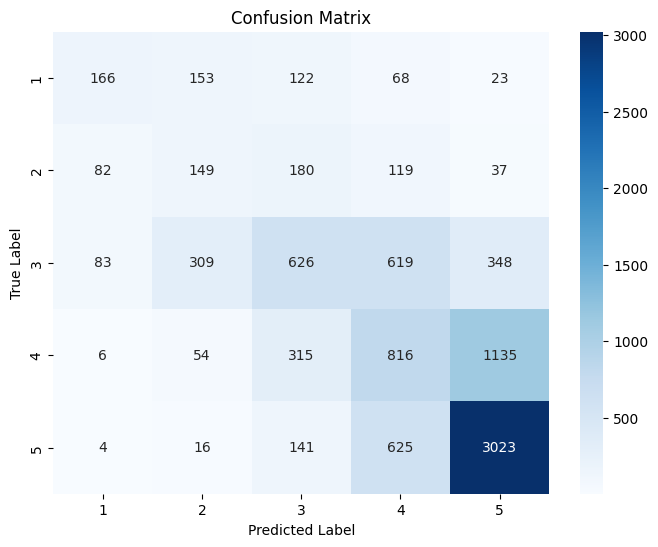

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(test_labels_list, predicted_ratings)

# 클래스 라벨 설정 (1부터 5까지의 클래스)
class_labels = [1, 2, 3, 4, 5]

# 혼동 행렬을 데이터프레임으로 변환
confusion_df = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

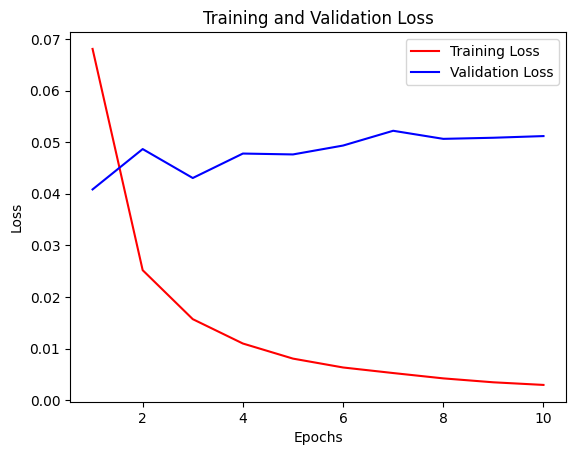

In [10]:
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실 값 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# epoch 수 추출
epochs = range(1, len(train_loss) + 1)

# 손실 값 시각화
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 단어 빈도수 확인 및 최빈 단어 제거

In [21]:
word_data = data['review_full'].apply(lambda x: x.split())

word_data.head()

0    [going, honk, quite, man, falesh, always, top,...
1    [frequent, visitor, chain, year, sad, restaura...
2    [excellent, staff, cooperative, gentle, specia...
3    [always, visit, place, always, offer, good, fo...
4    [lot, appraise, chef, deepak, chef, wangmo, se...
Name: review_full, dtype: object

In [22]:
from functools import reduce

word_list = list(reduce(lambda x, y: x+y,word_data))

print(len(word_list))

495759


In [23]:
from collections import Counter

count = Counter(word_list)

count 

Counter({'going': 523,
         'honk': 19,
         'quite': 1091,
         'man': 57,
         'falesh': 4,
         'always': 956,
         'top': 433,
         'job': 140,
         'making': 221,
         'beautiful': 456,
         'cocktail': 351,
         'perfection': 74,
         'advising': 3,
         'best': 2597,
         'delicacy': 118,
         'remarkable': 29,
         'gr': 25,
         'keep': 432,
         'sahil': 15,
         'bhalla': 20,
         'frequent': 35,
         'visitor': 102,
         'chain': 149,
         'year': 615,
         'sad': 79,
         'restaurant': 6065,
         'decline': 6,
         'seems': 233,
         'management': 164,
         'completely': 115,
         'indifferent': 19,
         'unfortunate': 7,
         'experience': 2353,
         'lunch': 1206,
         'afternoon': 170,
         'service': 6877,
         'poor': 344,
         'server': 392,
         'bother': 37,
         'listen': 32,
         'request': 135,
         '

In [24]:
word_count = {} #딕셔너리 객체
top_word_list = []
for tag, counts in count.most_common(20): #상위 50개
    if(len(str(tag))>1):
        word_count[tag] = counts
        print("%s : %d" % (tag, counts))
        top_word_list.append(str(tag))

food : 15160
good : 9787
place : 8936
service : 6877
restaurant : 6065
great : 4453
one : 3731
staff : 3394
time : 3357
nice : 3020
indian : 2963
delhi : 2891
visit : 2783
taste : 2720
best : 2597
also : 2568
dish : 2514
really : 2472
chicken : 2466


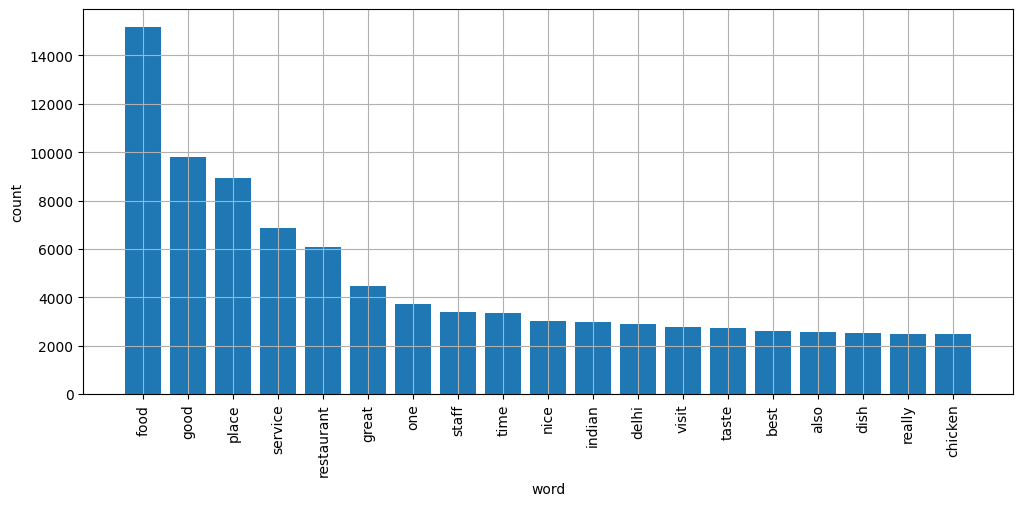

In [25]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(12,5))
plt.xlabel("word")
plt.ylabel("count")
plt.grid(True)

sorted_Keys = sorted(word_count, key=word_count.get, reverse=True) #keyword
sorted_Values = sorted(word_count.values(), reverse=True)          #count

plt.bar(range(len(word_count)), sorted_Values, align='center')
plt.xticks(range(len(word_count)), list(sorted_Keys), rotation='vertical')

plt.show()

In [26]:
print(top_word_list)

['food', 'good', 'place', 'service', 'restaurant', 'great', 'one', 'staff', 'time', 'nice', 'indian', 'delhi', 'visit', 'taste', 'best', 'also', 'dish', 'really', 'chicken']


In [27]:
data['review_full'] = data['review_full'].apply(lambda x: ' '.join(word for word in x.split() if word not in top_word_list))

In [28]:
data['review_full'] 


0        going honk quite man falesh always top job mak...
1        frequent visitor chain year sad decline seems ...
2        excellent cooperative gentle specially amit he...
3        always always offer thing hate long ques lunch...
4        lot appraise chef deepak chef wangmo ajay hari...
                               ...                        
19995    smallest outlet domino crowded outside kashmir...
19996    dont like pizza whenever want eat something qu...
19997     want waste money pls go satisfactory full insect
19998    always enjoyed gulati got appreciation guest t...
19999    auspicious day navratras around chaayos come e...
Name: review_full, Length: 17742, dtype: object

## 부정, 긍정 텍스트 단어 영향도 분석

In [30]:

# rating_review 값이 4 또는 5인 로우 추출
good_reviews = data[data['rating_review'].isin([4, 5])]['review_full']
# rating_review 값이 1 또는 2인 로우 추출
bad_reviews = data[data['rating_review'].isin([1, 2])]['review_full']


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

# 좋은 호텔 리뷰에서 TF-IDF 점수 계산
good_tfidf = tfidf.fit_transform(good_reviews)
good_tfidf_scores = good_tfidf.mean(axis=0)


# 나쁜 호텔 리뷰에서 TF-IDF 점수 계산
bad_tfidf = tfidf.transform(bad_reviews)
bad_tfidf_scores = bad_tfidf.mean(axis=0)

# 단어와 해당 단어의 TF-IDF 점수를 딕셔너리로 저장
word_scores = {}



## 버전문제로 임시로 아래의 메소드 사용
# feature_names = tfidf.get_feature_names() 
feature_names = tfidf.get_feature_names_out() 
for idx, score in enumerate(good_tfidf_scores.tolist()[0]):
    word = feature_names[idx]
    word_scores[word] = score

# 좋은 호텔 리뷰에서 TF-IDF 점수가 높은 상위 10개 단어 출력
top_10_good_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 words in good hotel reviews:")
for word, score in top_10_good_words:
    print(f"{word}: {score}")

print('\n')

# 나쁜 호텔 리뷰에서 TF-IDF 점수가 높은 상위 10개 단어 출력
word_scores = {}
for idx, score in enumerate(bad_tfidf_scores.tolist()[0]):
    word = feature_names[idx]
    word_scores[word] = score
    
top_10_bad_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 words in bad hotel reviews:")
for word, score in top_10_bad_words:
    print(f"{word}: {score}")

Top 10 words in good hotel reviews:
excellent: 0.020413307146320284
amazing: 0.01852340775480334
ambience: 0.017543918309833068
experience: 0.01642677626881041
delicious: 0.015737590297177497
must: 0.015092419649372118
well: 0.015039267063347834
try: 0.013830476640815065
dinner: 0.013511031525447682
friend: 0.013295867388013482


Top 10 words in bad hotel reviews:
bad: 0.03365453666749887
poor: 0.025841143478377904
average: 0.0240111522139696
ordered: 0.022792060472657357
worst: 0.02250613528477304
even: 0.02141934274196701
pathetic: 0.02039222196424544
quality: 0.019805201706470592
order: 0.01846212670821578
like: 0.017738451219034734


# kmeans_cluster
* 긍부정 포함 
* 긍정 텍스트
* 부정 텍스트

In [73]:
reviews = data['review_full']

# rating_review 값이 4 또는 5인 로우 추출
good_reviews = data[data['rating_review'].isin([4, 5])]['review_full']
# rating_review 값이 1 또는 2인 로우 추출
bad_reviews = data[data['rating_review'].isin([1, 2])]['review_full']

## good_reviews선택하여 클러스터링 할때 사용
# reviews = good_reviews

## bad_review 선택하여 클러스터링 할때 사용
# reviews = bad_reviews


tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
avg_sequence_length = int(np.mean([len(seq) for seq in sequences]))
avg_sequence_length = 10
# 시퀀스 자르기
truncated_sequences = []
for seq in sequences:
    if len(seq) > avg_sequence_length:
        truncated_seq = seq[:avg_sequence_length]
    else:
        truncated_seq = seq
    truncated_sequences.append(truncated_seq)

# 패딩
padded_sequences = pad_sequences(truncated_sequences, maxlen=avg_sequence_length)



In [74]:
print(padded_sequences)

[[ 152 2458   35 ...  573  385  180]
 [1659  761  540 ...  494  685 2459]
 [   7 1661 3572 ...  193  830 1719]
 ...
 [   0    0   96 ... 1918  155 3033]
 [  56   70  580 ... 2707  294  185]
 [6124   48 5096 ...    6 3843 3651]]


c:\Users\JORON\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


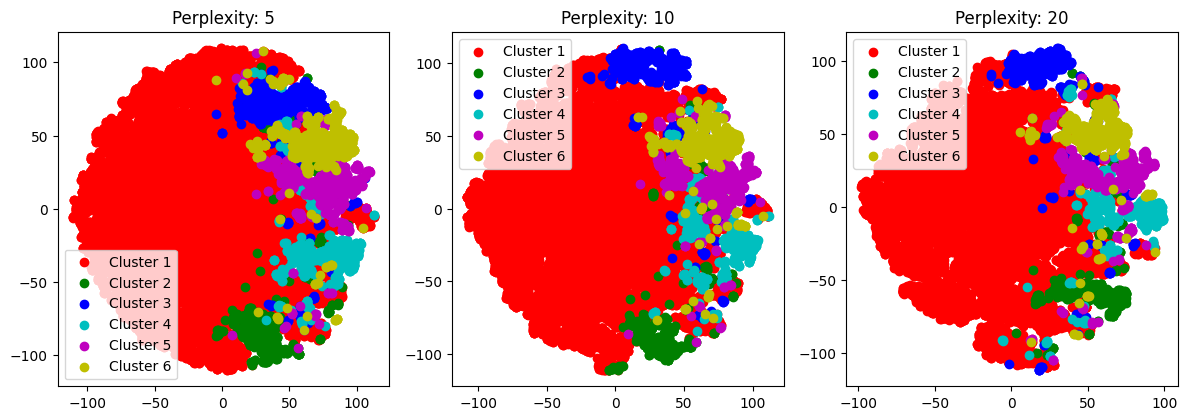

In [75]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# k-means 클러스터링 수행
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(padded_sequences)

# perplexities = [5, 10, 15, 25, 50, 100]
perplexities = [5, 10, 20]

plt.figure(figsize=(12, 8))
for i, perplexity in enumerate(perplexities):
    plt.subplot(2, 3, i + 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_representation = tsne.fit_transform(padded_sequences)

    # 시각화
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    for j in range(num_clusters):
        plt.scatter(tsne_representation[cluster_labels == j, 0], tsne_representation[cluster_labels == j, 1], color=colors[j], label=f'Cluster {j+1}')
    plt.title(f'Perplexity: {perplexity}')
    plt.legend()

plt.tight_layout()
plt.show()

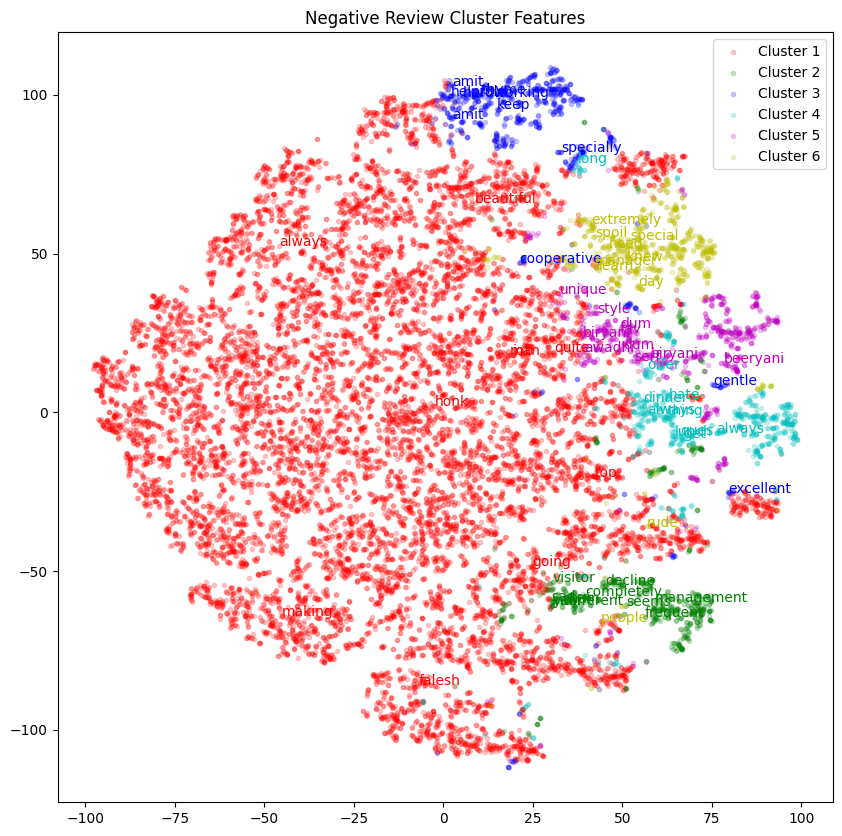

In [80]:
# 선택한 perplexity에 대한 클러스터 특징 확인
selected_perplexity = 20  # 예시로 선택한 perplexity 값
selected_cluster_label = cluster_labels[perplexities.index(selected_perplexity)]

# 선택한 클러스터에 포함된 특징 추출
features = padded_sequences[cluster_labels == selected_cluster_label]

# 특징을 단어로 역추적
reverse_word_index = {index: word for word, index in word_index.items()}
words = [[reverse_word_index.get(index, '') for index in feature] for feature in features]

# 단어를 클러스터 위에 표시
plt.figure(figsize=(10, 10))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i in range(num_clusters):
    cluster_features = [word for word in words[i] if word != '']
    for j in range(min(10, len(cluster_features))):  # 최대 10개 단어만 표시
        plt.text(tsne_representation[cluster_labels == i, 0][j],
                 tsne_representation[cluster_labels == i, 1][j],
                 cluster_features[j],
                 color=colors[i])
    plt.scatter(tsne_representation[cluster_labels == i, 0],
                tsne_representation[cluster_labels == i, 1],
                marker='.',
                c=colors[i],
                alpha=0.2,
                label=f'Cluster {i+1}')
plt.title(f'Negative Review Cluster Features')
plt.legend()
plt.show()

In [81]:
import pandas as pd

# 데이터 프레임 초기화
df_clusters = pd.DataFrame(columns=['Cluster', 'Word'])

# 각 클러스터에 대해 데이터 프레임 열 생성
for i in range(num_clusters):
    cluster_features = [word for word in words[i] if word != '']
    cluster_data = pd.DataFrame({'Cluster': [i+1] * len(cluster_features),
                                 'Word': cluster_features})
    df_clusters = pd.concat([df_clusters, cluster_data], ignore_index=True)

# 데이터 프레임 출력
print(df_clusters)
print(cluster_features)

   Cluster         Word
0        1        going
1        1         honk
2        1        quite
3        1          man
4        1       falesh
5        1       always
6        1          top
7        1          job
8        1       making
9        1    beautiful
10       2     frequent
11       2      visitor
12       2        chain
13       2         year
14       2          sad
15       2      decline
16       2        seems
17       2   management
18       2   completely
19       2  indifferent
20       3    excellent
21       3  cooperative
22       3       gentle
23       3    specially
24       3         amit
25       3      helpful
26       3  hardworking
27       3         keep
28       3         amit
29       3        thyme
30       4       always
31       4       always
32       4        offer
33       4        thing
34       4         hate
35       4         long
36       4         ques
37       4        lunch
38       4       dinner
39       4          get
40       5     b

In [78]:
result = df_clusters.groupby('Cluster')['Word'].apply(list).reset_index()


result['Word']

0    [going, honk, quite, man, falesh, always, top,...
1    [frequent, visitor, chain, year, sad, decline,...
2    [excellent, cooperative, gentle, specially, am...
3    [always, always, offer, thing, hate, long, que...
4    [beeryani, serf, biryani, dum, awadhi, style, ...
5    [special, day, people, knew, spoil, manager, e...
Name: Word, dtype: object

In [79]:
for j in range(6):
    for i in result.iloc[j,:]:
        print(i)

1
['going', 'honk', 'quite', 'man', 'falesh', 'always', 'top', 'job', 'making', 'beautiful']
2
['frequent', 'visitor', 'chain', 'year', 'sad', 'decline', 'seems', 'management', 'completely', 'indifferent']
3
['excellent', 'cooperative', 'gentle', 'specially', 'amit', 'helpful', 'hardworking', 'keep', 'amit', 'thyme']
4
['always', 'always', 'offer', 'thing', 'hate', 'long', 'ques', 'lunch', 'dinner', 'get']
5
['beeryani', 'serf', 'biryani', 'dum', 'awadhi', 'style', 'dum', 'biryani', 'fav', 'unique']
6
['special', 'day', 'people', 'knew', 'spoil', 'manager', 'extremely', 'rude', 'need', 'learn']
